<a href="https://colab.research.google.com/github/seongyeon1/twitterNLP/blob/main/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# DataFrame
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_IN_PATH = '/content/drive/MyDrive/ColabNotebooks/datasets/sentiments/'

In [ ]:
train_data = pd.read_csv(DATA_IN_PATH + 'train.csv')
test_data = pd.read_csv(DATA_IN_PATH + 'test.csv')
train_data.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [ ]:
train_data.loc[44].tweet

'Acquisto del week end. #iphone8 #iphone8plus #apple gril moment #italy… https://www.instagram.com/p/BZY3Xcxh0qV/'

In [ ]:
df = pd.concat([train_data, test_data])

In [ ]:
!pip install unidecode
!pip install ktrain
!pip install wordninja

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 981 kB 59.1 MB/s 
     |████████████████████████████████| 263 kB 59.9 MB/s 
     |████████████████████████████████| 2.8 MB 51.7 MB/s 
     |████████████████████████████████| 1.2 MB 56.2 MB/s 
     |████████████████████████████████| 468 kB 55.0 MB/s 
     |████████████████████████████████| 880 kB 59.2 MB/s 
     |████████████████████████████████| 3.3 MB 52.9 MB/s 
     |████████████████████████████████| 596 kB 60.7 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.2-py3-none-any.whl size=25313063 sha256=60f985fae961eba3f9eb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 541 kB 7.6 MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541551 sha256=4ed4bf04ec8c337841fa79f62bd5f201d104f3f864faa1d77ac8cf56c5d98f38
  Stored in directory: /root/.cache/pip/wheels/dd/3f/eb/a2692e3d2b9deb1487b09ba4967dd6920bd5032bfd9ff7acfc
Successfully built wordninja


In [ ]:
import re
import unidecode
import numpy as np
import pandas as pd
import ktrain
from ktrain import text
import wordninja
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def clean_tweet(text):

    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', 'good', text)
    text = re.sub('^^', 'good', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', 'laugh', text)
    # Sad -- :-(, : (, :(, ):, )-:
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', 'bad', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', 'sad', text)

    
    # lower-case all characters
    text=text.lower()
    
    # remove twitter handles
    text= re.sub(r'@\S+', '',text) 
    
    # remove urls
    text= re.sub(r'http\S+', '',text) 
    text= re.sub(r'pic.\S+', '',text)
      
    # replace unidecode characters
    text=unidecode.unidecode(text)
      
    # regex only keeps characters
    text= re.sub(r"[^a-zA-Z+']", ' ',text)
    
    # keep words with length>1 only
    text=re.sub(r'\s+[a-zA-Z]\s+', ' ', text+' ') 

    # split words like 'whatisthis' to 'what is this'
    def preprocess_wordninja(sentence):      
        def split_words(x):
            x=wordninja.split(x)
            x= [word for word in x if len(word)>1]
            return x
        new_sentence=[ ' '.join(split_words(word)) for word in sentence.split() ]
        return ' '.join(new_sentence)
    
    text=preprocess_wordninja(text)
 
    # regex removes repeated spaces, strip removes leading and trailing spaces
    text= re.sub("\s[\s]+", " ",text).strip()  
    
    return text

In [ ]:
%%time
df.tweet = df.tweet.apply(lambda x: clean_tweet(x))

CPU times: user 7.92 s, sys: 35.2 ms, total: 7.96 s
Wall time: 11.5 s


In [ ]:
train_data.tweet.iloc[1]

'Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/'

In [ ]:
df.tweet.iloc[1]

'good finally trans paran silicon case thanks to my uncle good yay sony peri sony ex peri as'

In [ ]:
df_train = df[:7920]
df_test = df[7920:]

In [ ]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [ ]:
# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = 0
NEGATIVE = 1
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

stop_words = set(stopwords.words("english"))
stop_words_list = ['no', 'nor', 'not', 'don', "don't", 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't",
                   "hadn't", 'hasn', "hasn't", "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                   "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

for i in stop_words_list:
  stop_words.remove((i))

print(stop_words)

{"that'll", 'where', 'if', 'we', 'have', 'yourself', 'own', 'ourselves', 'further', 'most', 'is', 'why', 'his', 'himself', 've', 'both', 'few', 'of', 'an', 'haven', 'their', 'too', 'having', 'then', 'from', 'very', 'here', 'below', 'are', 'doing', 'only', 'o', 'other', "you're", 'until', 'can', 'has', 'through', 'between', 'him', 'such', 'itself', "you've", 'yours', 'did', 'me', 'those', 'off', 'any', 'my', 'by', 'she', 'with', 'and', 'now', 'll', 'do', 'ours', 'for', 'there', 'yourselves', 'to', 'because', 'd', 'm', 'its', 'over', 'which', 'he', 'some', 'themselves', 'hers', 'or', 'it', 'against', 'before', 'your', 'out', 'y', 'was', 'under', 'when', 'ma', 'does', 'being', 'after', 'what', 'the', "you'd", 'above', 'how', 'during', 'our', 'while', 'all', 's', 'but', 'in', 'into', 'them', 'these', 'her', 'hadn', 'up', 'they', 'be', 'as', 'should', 'herself', 'had', 'down', 'each', 'that', 'a', "it's", 'theirs', "you'll", 'so', 'once', 'whom', 'were', 'just', 'this', 'again', "should've"

In [ ]:
%%time
documents = [_text.split() for _text in df_train.tweet]

CPU times: user 10.4 ms, sys: 2.98 ms, total: 13.4 ms
Wall time: 15 ms


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

w2v_model.wv.most_similar("apple")

Vocab size 1568


[('cook', 0.43097302317619324),
 ('crappy', 0.4260380268096924),
 ('yosemite', 0.4020828604698181),
 ('customers', 0.3841594159603119),
 ('tim', 0.36642375588417053),
 ('huge', 0.35862305760383606),
 ('company', 0.3537476062774658),
 ('os', 0.349231481552124),
 ('making', 0.34378618001937866),
 ('useless', 0.33527839183807373)]

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 10877
CPU times: user 201 ms, sys: 89.2 ms, total: 291 ms
Wall time: 199 ms


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.tweet), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.tweet), maxlen=SEQUENCE_LENGTH)

CPU times: user 174 ms, sys: 2.84 ms, total: 177 ms
Wall time: 177 ms


In [ ]:
labels = df_train.label.unique().tolist()
labels

[0.0, 1.0]

In [ ]:
df_test.label = df_test.label.fillna(0)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.label.tolist())

y_train = encoder.transform(df_train.label.tolist())
y_test = encoder.transform(df_test.label.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (7920, 1)
y_test (1953, 1)


In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(10877, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Embedding(1000, 300, input_length=300))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          300000    
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 460,501
Trainable params: 460,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

Epoch 1/8
7/7 [==============================] - 13s 1s/step - loss: 0.6540 - accuracy: 0.7088 - val_loss: 0.5661 - val_accuracy: 0.7323 - lr: 0.0010
Epoch 2/8
7/7 [==============================] - 9s 1s/step - loss: 0.5315 - accuracy: 0.7457 - val_loss: 0.4948 - val_accuracy: 0.7323 - lr: 0.0010
Epoch 3/8
7/7 [==============================] - 10s 1s/step - loss: 0.4426 - accuracy: 0.7729 - val_loss: 0.3873 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 4/8
7/7 [==============================] - 9s 1s/step - loss: 0.3212 - accuracy: 0.8396 - val_loss: 0.2902 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 5/8
7/7 [==============================] - 9s 1s/step - loss: 0.2554 - accuracy: 0.8889 - val_loss: 0.2628 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 6/8
7/7 [==============================] - 10s 1s/step - loss: 0.2372 - accuracy: 0.8997 - val_loss: 0.2573 - val_accuracy: 0.8965 - lr: 0.0010
Epoch 7/8
7/7 [==============================] - 10s 1s/step - loss: 0.2245 - accuracy: 0.9028 - val_lo

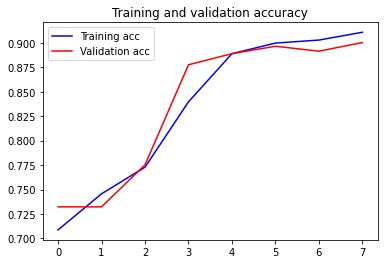

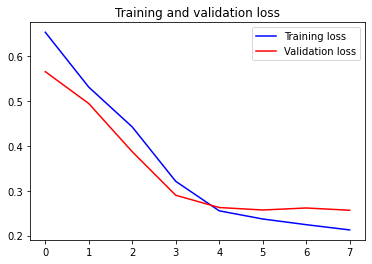

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score):
  return POSITIVE if score < 0.5 else NEGATIVE

In [ ]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict("I don't love iphone")

{'elapsed_time': 0.3135802745819092, 'label': 0, 'score': 0.4100114405155182}

In [ ]:
predict("I hate apple")

{'elapsed_time': 0.12326669692993164, 'label': 1, 'score': 0.8697569966316223}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.label)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

1/1 [==============================] - 0s 427ms/step
CPU times: user 402 ms, sys: 69.5 ms, total: 472 ms
Wall time: 478 ms


In [ ]:
submission = pd.read_csv((DATA_IN_PATH + 'sample_submission.csv'))

In [ ]:
submission.label = y_pred_1d

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

In [ ]:
submission.to_csv((DATA_IN_PATH + 'submission_stopwords_20220528.csv'), index=False)